In [250]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import copy

In [251]:
linear_trend = np.linspace(0, 10, 5)

In [252]:
x = np.linspace(0, 10 * np.pi, 10)
increasing_sine_wave = np.sin(x) + 0.1 * x  # Increasing sine wave

In [253]:
exponential_trend = np.exp(np.linspace(0, 2, 13))

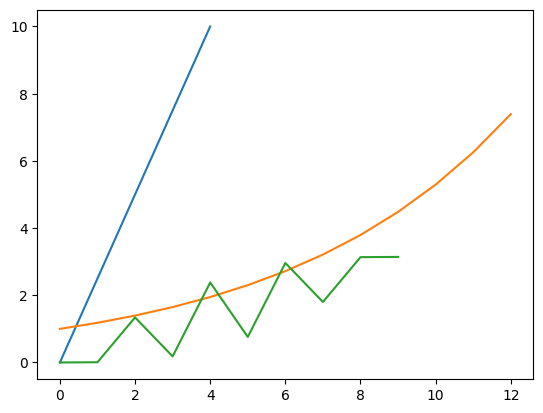

In [254]:
plt.plot(linear_trend)
plt.plot(exponential_trend)
plt.plot(increasing_sine_wave)
# plt.legend(['linear', ''])
plt.show()

In [255]:
print(linear_trend)
print(exponential_trend)
print(increasing_sine_wave)

[ 0.   2.5  5.   7.5 10. ]
[1.         1.18136041 1.39561243 1.64872127 1.94773404 2.30097589
 2.71828183 3.21127054 3.79366789 4.48168907 5.29449005 6.25470095
 7.3890561 ]
[0.         0.00704571 1.34091931 0.18117215 2.38107115 0.7605215
 2.96042051 1.80067334 3.13454695 3.14159265]


# trend data

In [256]:
np.random.seed(42)  # for reproducibility
n_samples = 10000
ages = np.concatenate([
    np.random.normal(60, 10, int(0.8 * n_samples)),  # 70% of the data around age 60
    np.random.normal(30, 10, int(0.2 * n_samples))   # 30% of the data around age 30
])
ages = np.clip(ages, 0, 100)  

In [257]:
def generate_trends(num_sequences, max_length, beta, noise):
    np.random.seed(42)  # for reproducibility
    data = {}

    for patid in tqdm(range(num_sequences)):
        length = np.random.randint(5, max_length)
        trend_type = np.random.choice(['increasing', 'decreasing'])
        x = np.linspace(0, 1, length)
        
        if trend_type == 'increasing':
            y = np.polyval(np.polyfit(x, np.random.rand(length) + np.linspace(0, 2, length), 2), x) +ages[patid]*beta
        else:
            y = np.polyval(np.polyfit(x, np.random.rand(length) + np.linspace(2, 0, length), 2), x) +ages[patid]*beta

        # Adding some noise
        y += np.random.normal(scale=noise, size=length)
        
        # Ensuring no exact linear trends
        y = y + np.sin(2 * np.pi * np.random.rand() * x)
        
        data[patid] = {}
        data[patid]['seq'] = y
        data[patid]['age'] = ages[patid]
        if trend_type == 'increasing':
            data[patid]['label'] = 1
        else:
            data[patid]['label'] = 0

    return data

# Generate 10 sequences with a maximum length of 50
trends_data = generate_trends(10000, 50, 0.1, 0.6)


100%|██████████| 10000/10000 [00:01<00:00, 6173.11it/s]


In [258]:
la = []
for k,v in trends_data.items():
    la.append(v['label'])

In [259]:
sum(la)

5079

6.542945507351557


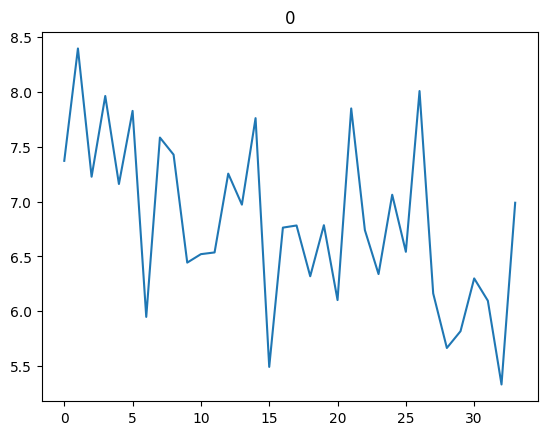

In [260]:
i = 2546
plt.plot(trends_data[i]['seq'])
plt.title(trends_data[i]['label'])
print(trends_data[i]['seq'][25])

In [261]:
import pickle
with open('datasets/noise0.6_beta0.1.pickle','wb') as handle:
    pickle.dump(trends_data, handle)

# Trend data with missingness

### missing completely at random (MCAR)

In [262]:
import copy

In [263]:
def introduce_mcar(data, missing_rate=0.3):
    np.random.seed(111)
    for patid, values in data.items():
        seq = values['seq']
        mask = np.random.rand(len(seq)) > missing_rate # if random number is greater than missing_rate, the value will be kept. As the random number is from 0 to 1 there are 1-missing_rate percent chance that the value will be kept
        seq[~mask] = np.nan  # Introducing missing values
        data[patid]['seq'] = seq
    return data

In [264]:
import pickle
with open('datasets/noise0.6_beta0.1.pickle','rb') as handle:
    trends_data = pickle.load(handle)

In [265]:
data_miss = introduce_mcar(copy.deepcopy(trends_data))

Text(0.5, 1.0, '0')

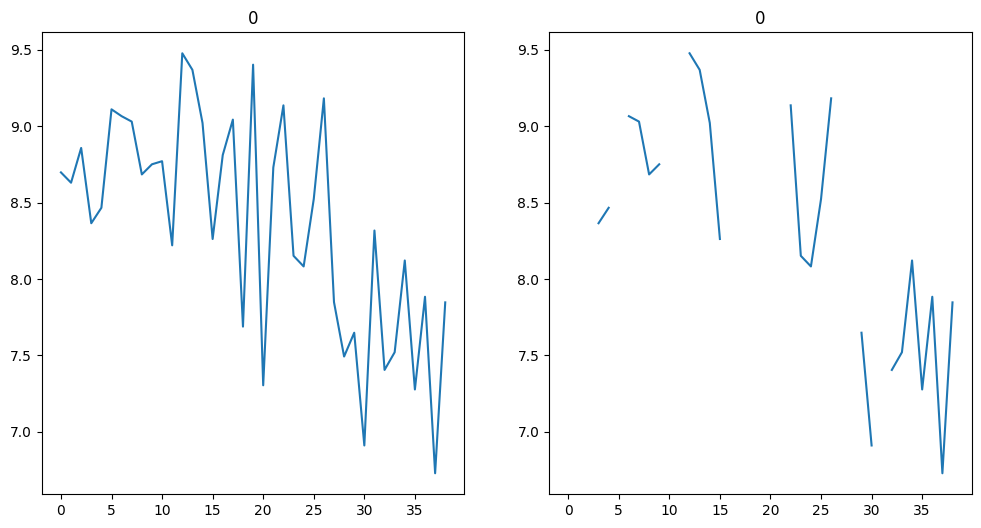

In [266]:
# miss = 0.1
i = 70
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(trends_data[i]['seq'])
axes[0].set_title(trends_data[i]['label'])

axes[1].plot(data_miss[i]['seq'])
axes[1].set_title(data_miss[i]['label'])

In [267]:
data_miss[0]

{'seq': array([9.56717963,        nan, 9.16822658, 7.85247289,        nan,
               nan,        nan, 9.07508737,        nan, 8.76370568,
        8.04298938,        nan,        nan, 9.51919765, 9.07494484,
               nan, 9.02878058,        nan,        nan, 9.14315123,
        9.37332568, 9.29095372, 8.20493469, 8.49798201, 8.8560254 ,
        9.21501931, 8.31323731,        nan, 7.87476784,        nan,
        8.9580173 , 9.24794569, 8.35316391,        nan, 8.53306131,
               nan, 8.44645261, 9.10690611, 8.11554341, 9.02728596,
        6.46664398, 8.4801838 , 7.98641582]),
 'age': np.float64(64.96714153011233),
 'label': 0}

In [268]:
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp

In [269]:
with open('datasets/mcar_beta0.1.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

In [270]:
max_len = 0
for i, d in data_miss.items():
    if max_len<len(d['seq']):
        max_len = len(d['seq'])

In [271]:
max_len

49

### Missing at random (MAR)

In [272]:
def introduce_mar(data, missing_rate = 0.3, age_threshold = 50):
    np.random.seed(111)
    for patid, values in data.items():
        seq = values['seq']
        age = values.get('age')
        
        # calculate missing rate (assume to be 0.15 higher above age threshold)
        adjusted_missing_rate = missing_rate if age < age_threshold else min(1, missing_rate + 0.15)
        
        # create mask to introduce missing values
        mask = np.random.rand(len(seq)) > adjusted_missing_rate
        seq[~mask] = np.nan
        
        data[patid]['seq'] = seq
    return data

Text(0.5, 1.0, '0')

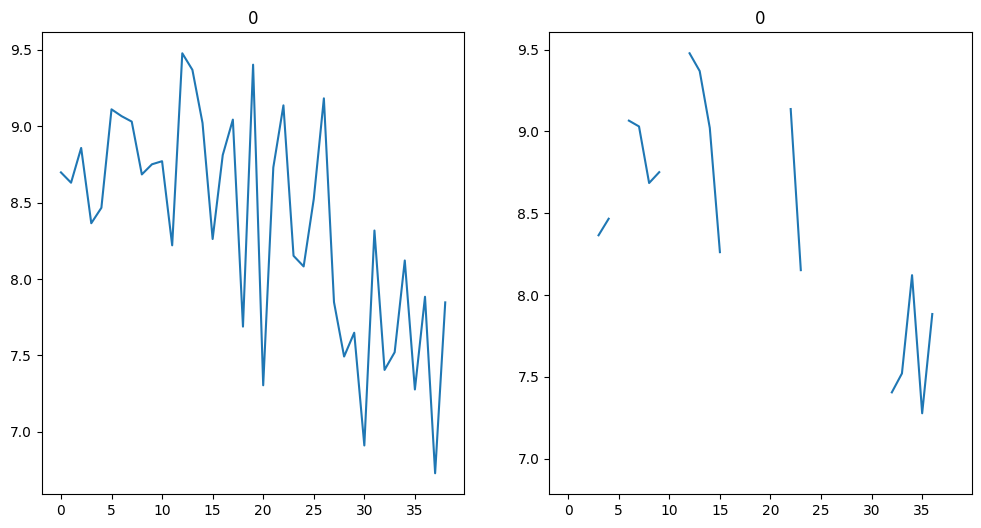

In [273]:
import pickle
with open('datasets/noise0.6_beta0.1.pickle','rb') as handle:
    trends_data = pickle.load(handle)
    
data_miss = introduce_mar(copy.deepcopy(trends_data))

# miss = 0.1
i = 70
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(trends_data[i]['seq'])
axes[0].set_title(trends_data[i]['label'])

axes[1].plot(data_miss[i]['seq'])
axes[1].set_title(data_miss[i]['label'])

In [274]:
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp

In [275]:
with open('datasets/mar_beta0.1.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

In [276]:
max_len = 0
for i, d in data_miss.items():
    if max_len<len(d['seq']):
        max_len = len(d['seq'])
max_len

49

### Missing not at random (MNAR)

In [277]:
def introduce_mnar(data, base_rate = 0.3, value_threshold = 8.0, value_factor = 0.10):
    # mnar includes missingness that is dependent on unobserved variables
    np.random.seed(111)
    for patid, values in data.items():
        seq = values['seq']
        # if the sequence value is more than the value threshold, increase the missingness
        missing_rates = np.clip(base_rate + value_factor * np.maximum(seq - value_threshold, 0))
        
        mask = np.random.rand(len(seq)) > missing_rates
        seq[~mask] = np.nan
        
        data[patid]['seq'] = seq
    return data

Text(0.5, 1.0, '0')

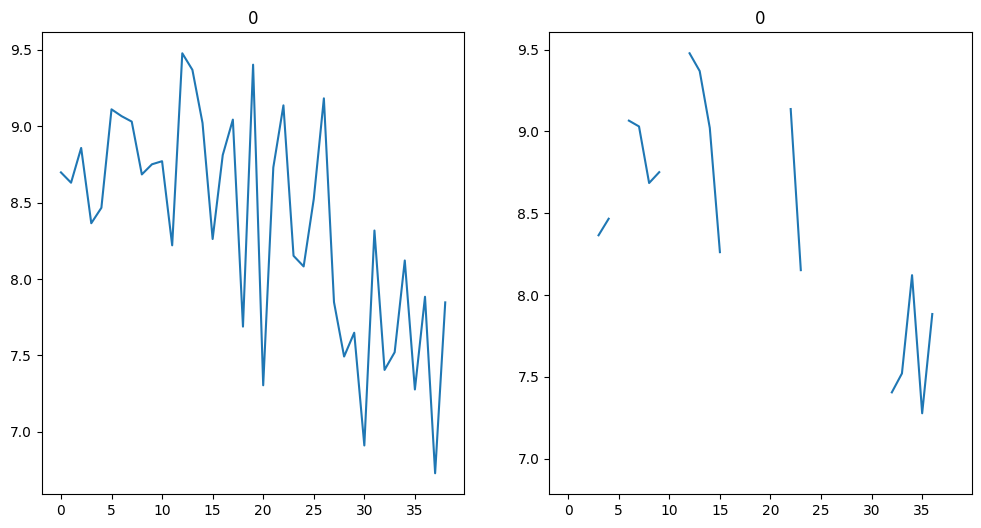

In [278]:
import pickle
with open('datasets/noise0.6_beta0.1.pickle','rb') as handle:
    trends_data = pickle.load(handle)
    
data_miss = introduce_mar(copy.deepcopy(trends_data))

# miss = 0.1
i = 70
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(trends_data[i]['seq'])
axes[0].set_title(trends_data[i]['label'])

axes[1].plot(data_miss[i]['seq'])
axes[1].set_title(data_miss[i]['label'])

In [279]:
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp

In [280]:
with open('datasets/mnar_beta0.1.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

In [281]:
max_len = 0
for i, d in data_miss.items():
    if max_len<len(d['seq']):
        max_len = len(d['seq'])
max_len

49

# model training/evaluation

In [338]:
name = 'noise0.6_beta0.1'
model_name = 'mlp_fix'
add_annot = '_lr0.01'

In [339]:
import pickle
with open('datasets/'+name+'.pickle','rb') as handle:
    trends_data = pickle.load(handle)

In [340]:
from training import Training
import torch
# torch.cuda.set_device(0)
device = torch.device('cpu')
# training = Training(trends_data, model = model_name, device = device)
# training = Training(trends_data, model = model_name, hidden_dim = 1536, device = device)
# training = Training(trends_data, model = model_name, input_dim = 1536, hidden_dim=128, device = device)
training = Training(trends_data, model = model_name, input_dim = 49, hidden_dim=1536, device = device)

normalize data
create datasets
create trainloaders


In [341]:
# Run the training process
best_model, train_loss, val_loss = training.training()


# Save the best model
model_save_path = f'outputs/baseline_{model_name}_{name}{add_annot}.pt'
torch.save(best_model, model_save_path)
print(f"Model saved as {model_save_path}")

# Save the training and validation losses
train_loss_save_path = f'outputs/train_losses_{model_name}_{name}{add_annot}.pickle'
with open(train_loss_save_path, 'wb') as handle:
    pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Training losses saved as {train_loss_save_path}")

val_loss_save_path = f'outputs/val_losses_{model_name}_{name}{add_annot}.pickle'
with open(val_loss_save_path, 'wb') as handle:
    pickle.dump(val_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Validation losses saved as {val_loss_save_path}")

Epoch [1/2000], Train Loss: 0.6294696385065714
Epoch [1/2000], Val Loss: 0.5451083989143372
Epoch [2/2000], Train Loss: 0.42677089349428815
Epoch [2/2000], Val Loss: 0.3388674403429031
Epoch [3/2000], Train Loss: 0.272545262157917
Epoch [3/2000], Val Loss: 0.22962778478860854
Epoch [4/2000], Train Loss: 0.19700974559783935
Epoch [4/2000], Val Loss: 0.17194192785024642
Epoch [5/2000], Train Loss: 0.15455125880241394
Epoch [5/2000], Val Loss: 0.13914410033822058
Epoch [6/2000], Train Loss: 0.12651388718684514
Epoch [6/2000], Val Loss: 0.11393348336219787
Epoch [7/2000], Train Loss: 0.11029243616263072
Epoch [7/2000], Val Loss: 0.10737876532971859
Epoch [8/2000], Train Loss: 0.09860749114304782
Epoch [8/2000], Val Loss: 0.11890676394104957
Epoch [9/2000], Train Loss: 0.08570225900411606
Epoch [9/2000], Val Loss: 0.08587275485694408
Epoch [10/2000], Train Loss: 0.0826017936989665
Epoch [10/2000], Val Loss: 0.0944144702348858
Epoch [11/2000], Train Loss: 0.07845751166995615
Epoch [11/2000],

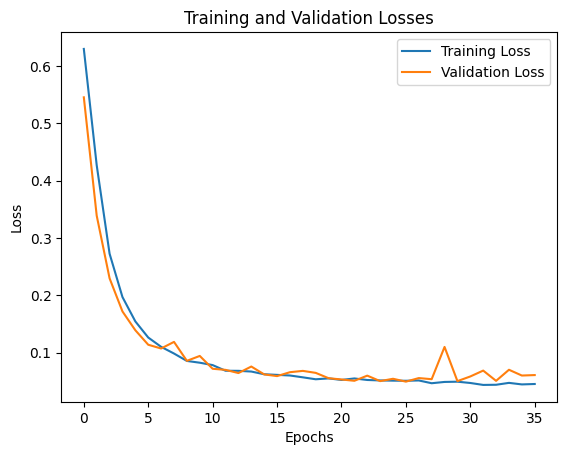

In [342]:
# Load training and validation losses
with open(f'outputs/train_losses_{model_name}_{name}{add_annot}.pickle', 'rb') as handle:
    tl = pickle.load(handle)
with open(f'outputs/val_losses_{model_name}_{name}{add_annot}.pickle', 'rb') as handle:
    vl = pickle.load(handle)

# Plot training and validation losses
plt.plot(tl, label='Training Loss')
plt.plot(vl, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Training and Validation Losses')
plt.show()

In [343]:
test_loader = training.data_splits.test_loader

In [344]:
# Initialize test loader and load the trained model
test_loader = training.data_splits.test_loader
model = training.model
device = training.device

# Load the trained model
trained_model_path = f'outputs/baseline_{model_name}_{name}{add_annot}.pt'
model.load_state_dict(torch.load(trained_model_path, map_location=device))

C:\Users\kr3164\AppData\Local\Temp\ipykernel_22100\926538778.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_model_path, map_loc

<All keys matched successfully>

In [345]:
trained_model_path

'outputs/baseline_mlp_fix_noise0.6_beta0.1_lr0.01.pt'

In [346]:
def create_padding_mask(seq_lengths, max_len):
    batch_size = len(seq_lengths)
    mask = torch.zeros(batch_size, max_len, dtype=torch.bool)
    for i, seq_len in enumerate(seq_lengths):
        mask[i, seq_len:] = True
    return mask

In [347]:
model.eval() 
all_outputs, all_labels = [], []
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.float().to(device)

        seq_lengths = [len(seq[seq != 0]) for seq in sequences]  # Calculate actual lengths without padding
        max_len = sequences.size(1)
        mask = create_padding_mask(seq_lengths, max_len).to(device)
        outputs = model(sequences, mask)
        all_outputs.extend(outputs.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

In [348]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import numpy as np

def roc_pr(outputs, labels, plot = 'no'):

    fpr, tpr, roc_thre = roc_curve(np.array(labels), np.array(outputs))
    pre, rec, pr_thre = precision_recall_curve(np.array(labels), np.array(outputs))

    if plot=='yes':
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
        roc_auc = auc(fpr, tpr)
        roc_label='AUROC'+': {:.4f}'.format(roc_auc)
        ax1.plot(fpr, tpr, color = 'b', label = roc_label)
        
        pr_auc = auc(rec, pre)
        pr_label = 'AUPR'+': {:.4f}'.format(pr_auc)
        ax2.plot(rec, pre, color='b', label=pr_label)
            
        # Set titles and labels
        ax1.set_title('ROC Curve')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right")
        
        ax2.set_title('Precision-Recall Curve')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left")

        # Show plot
        plt.tight_layout()
        plt.show()

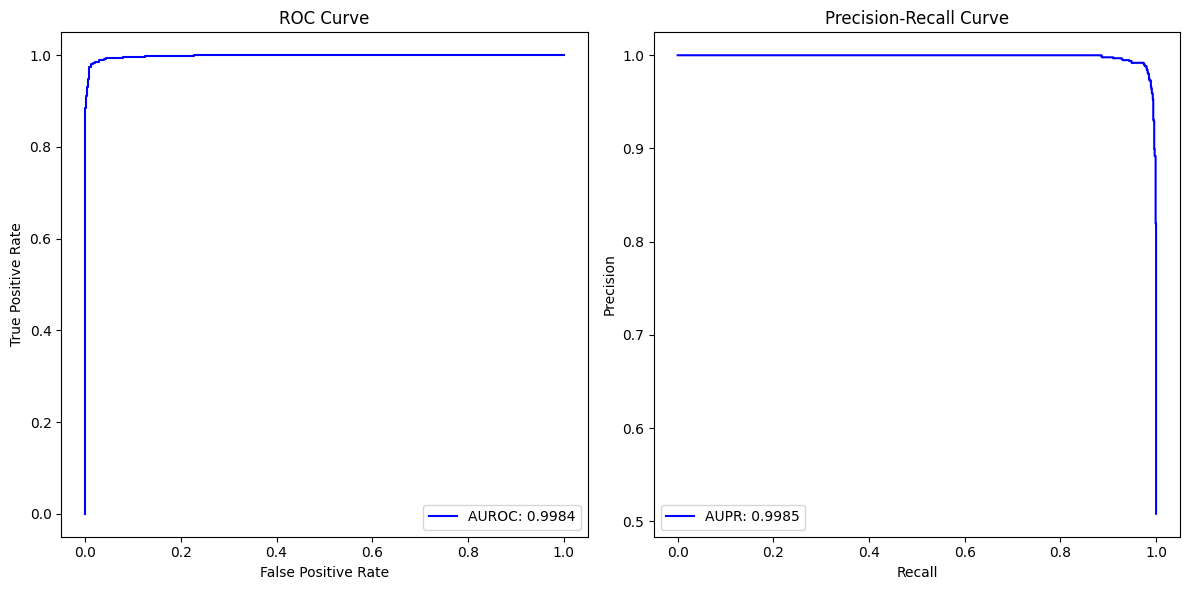

In [349]:
roc_pr(all_outputs, all_labels, plot = 'yes')